In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, confusion_matrix,classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from scipy.sparse import vstack, csr_matrix, csc_matrix
from collections import Counter
from imblearn.over_sampling import SMOTE
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import dump, load
import pickle

In [3]:
data_org = pd.read_csv("D:/STAT628m3/final_data2.csv")

In [4]:
data = data_org

In [5]:
data = data.drop(columns = "Year") 
data = data.drop(columns = "Month") 

data = data.drop(columns = "ArrDelay") 
data = data.drop(columns = "DepDelay") 
data = data.drop(columns = "ActualElapsedTime") 

In [6]:
# data['Year']=data['Year'].astype('category')
# data['Month']=data['Month'].astype('category')
# data['DayofMonth']=data['DayofMonth'].astype('category')
data['DayOfWeek']=data['DayOfWeek'].astype('category')
data['Operating_Airline ']=data['Operating_Airline '].astype('category')
data['Origin']=data['Origin'].astype('category')
data['Dest']=data['Dest'].astype('category')
data['DepTimeBlk'] = data['DepTimeBlk'].astype('category')
data['ArrTimeBlk'] = data['ArrTimeBlk'].astype('category')
data['Origin_HourlyWindDirection'] = data['Origin_HourlyWindDirection'].astype('category')
data['Dest_HourlyWindDirection'] = data['Dest_HourlyWindDirection'].astype('category')
data['Holiday'] = data['Holiday'].astype('category')
# data['Cancelled'] = data['Cancelled'].astype('category')

In [8]:
X = data.drop(columns=['Cancelled'])
y = data['Cancelled']

# One hot

In [9]:
categorical_features = X.select_dtypes(include=['category']).columns

In [10]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'  
)
preprocessor.fit(X)  

ColumnTransformer(remainder='passthrough',
                  transformers=[('cat', OneHotEncoder(handle_unknown='ignore'),
                                 Index(['DayOfWeek', 'Operating_Airline ', 'Origin', 'Dest', 'DepTimeBlk',
       'ArrTimeBlk', 'Origin_HourlyWindDirection', 'Dest_HourlyWindDirection',
       'Holiday'],
      dtype='object'))])

In [11]:
chunk_size = 500000  

X_transformed = csr_matrix((0, len(preprocessor.transform(X.iloc[:1]).toarray()[0])))

for start_row in range(0, len(X), chunk_size):
    end_row = min(start_row + chunk_size, len(X))
    data_chunk = X.iloc[start_row:end_row]  

    X_transformed_chunk = preprocessor.transform(data_chunk)

    print(f"Chunk shape: {X_transformed_chunk.shape}")

    X_transformed = vstack([X_transformed, X_transformed_chunk])

print(f"Transformed data shape: {X_transformed.shape}")

Chunk shape: (500000, 888)
Chunk shape: (500000, 888)
Chunk shape: (500000, 888)
Chunk shape: (500000, 888)
Chunk shape: (500000, 888)
Chunk shape: (500000, 888)
Chunk shape: (500000, 888)
Chunk shape: (500000, 888)
Chunk shape: (500000, 888)
Chunk shape: (500000, 888)
Chunk shape: (500000, 888)
Chunk shape: (500000, 888)
Chunk shape: (500000, 888)
Chunk shape: (500000, 888)
Chunk shape: (500000, 888)
Chunk shape: (500000, 888)
Chunk shape: (500000, 888)
Chunk shape: (500000, 888)
Chunk shape: (500000, 888)
Chunk shape: (200585, 888)
Transformed data shape: (9700585, 888)


# Split train and test

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=123)

In [13]:
categories = preprocessor.transformers_[0][1].categories_

encoded_feature_names = []
for feature, category in zip(categorical_features, categories):
    encoded_feature_names.extend([f"{feature}_{cat}" for cat in category])

numerical_feature_names_org = preprocessor.transformers_[1][2] if len(preprocessor.transformers_) > 1 else []
numerical_feature_names = []

for index in numerical_feature_names_org:
    if isinstance(index, int) and index < len(data.columns):
        numerical_feature_names.append(data.columns[index])
    else:
        numerical_feature_names.append(index)

all_feature_names = encoded_feature_names + numerical_feature_names

# SMOTE

In [14]:
smote = SMOTE(sampling_strategy=1, random_state=123)

n_samples, n_features = X_train.shape

X_resampled = np.empty((0, n_features))
y_resampled = np.empty((0,))

for start in tqdm(range(0, n_samples, chunk_size)):
    end = min(start + chunk_size, n_samples)
    X_chunk = X_train[start:end]
    y_chunk = y_train[start:end]
    
    X_resampled_chunk, y_resampled_chunk = smote.fit_resample(X_chunk, y_chunk)
    
    print(f"Shape of X_resampled_chunk: {X_resampled_chunk.shape}")
    print(f"X_resampled.shape: {X_resampled.shape}")
   
    if isinstance(X_resampled_chunk, (csr_matrix, csc_matrix)):
        X_resampled = vstack([X_resampled, X_resampled_chunk])

    if X_resampled.shape[0] == 0:
        X_resampled = X_resampled_chunk
    
    y_resampled = np.concatenate((y_resampled, y_resampled_chunk))

print("Resampled X shape:", X_resampled.shape)
print("Resampled y shape:", y_resampled.shape)

print("Class distribution after SMOTE:", Counter(y_resampled))

  0%|                                                                                           | 0/16 [00:00<?, ?it/s]

Shape of X_resampled_chunk: (980308, 888)
X_resampled.shape: (0, 888)


  6%|█████▏                                                                             | 1/16 [00:06<01:35,  6.37s/it]

Shape of X_resampled_chunk: (980324, 888)
X_resampled.shape: (980308, 888)


 12%|██████████▍                                                                        | 2/16 [00:13<01:33,  6.69s/it]

Shape of X_resampled_chunk: (980370, 888)
X_resampled.shape: (1960632, 888)


 19%|███████████████▌                                                                   | 3/16 [00:20<01:30,  7.00s/it]

Shape of X_resampled_chunk: (980580, 888)
X_resampled.shape: (2941002, 888)


 25%|████████████████████▊                                                              | 4/16 [00:28<01:26,  7.17s/it]

Shape of X_resampled_chunk: (980082, 888)
X_resampled.shape: (3921582, 888)


 31%|█████████████████████████▉                                                         | 5/16 [00:36<01:25,  7.77s/it]

Shape of X_resampled_chunk: (980060, 888)
X_resampled.shape: (4901664, 888)


 38%|███████████████████████████████▏                                                   | 6/16 [00:46<01:22,  8.23s/it]

Shape of X_resampled_chunk: (980048, 888)
X_resampled.shape: (5881724, 888)


 44%|████████████████████████████████████▎                                              | 7/16 [00:55<01:16,  8.53s/it]

Shape of X_resampled_chunk: (980096, 888)
X_resampled.shape: (6861772, 888)


 50%|█████████████████████████████████████████▌                                         | 8/16 [01:04<01:09,  8.72s/it]

Shape of X_resampled_chunk: (980410, 888)
X_resampled.shape: (7841868, 888)


 56%|██████████████████████████████████████████████▋                                    | 9/16 [01:13<01:02,  8.98s/it]

Shape of X_resampled_chunk: (980140, 888)
X_resampled.shape: (8822278, 888)


 62%|███████████████████████████████████████████████████▎                              | 10/16 [01:25<00:58,  9.79s/it]

Shape of X_resampled_chunk: (980466, 888)
X_resampled.shape: (9802418, 888)


 69%|████████████████████████████████████████████████████████▍                         | 11/16 [01:36<00:51, 10.26s/it]

Shape of X_resampled_chunk: (980240, 888)
X_resampled.shape: (10782884, 888)


 75%|█████████████████████████████████████████████████████████████▌                    | 12/16 [01:48<00:43, 10.81s/it]

Shape of X_resampled_chunk: (980532, 888)
X_resampled.shape: (11763124, 888)


 81%|██████████████████████████████████████████████████████████████████▋               | 13/16 [02:01<00:34, 11.43s/it]

Shape of X_resampled_chunk: (980310, 888)
X_resampled.shape: (12743656, 888)


 88%|███████████████████████████████████████████████████████████████████████▊          | 14/16 [02:22<00:28, 14.40s/it]

Shape of X_resampled_chunk: (980648, 888)
X_resampled.shape: (13723966, 888)


 94%|████████████████████████████████████████████████████████████████████████████▉     | 15/16 [02:44<00:16, 16.69s/it]

Shape of X_resampled_chunk: (510600, 888)
X_resampled.shape: (14704614, 888)


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [03:03<00:00, 11.44s/it]


Resampled X shape: (15215214, 888)
Resampled y shape: (15215214,)
Class distribution after SMOTE: Counter({0.0: 7607607, 1.0: 7607607})


In [17]:
X_train.shape

(7760468, 888)

In [18]:
X_resampled.shape

(15215214, 888)

# Random forest without SMOTE

In [27]:
# Consider imbalanced dataset
rf_model = RandomForestClassifier(n_estimators=50, max_depth=8, max_features="sqrt", n_jobs=-1, random_state=123, class_weight='balanced')

for i in tqdm(range(1, rf_model.n_estimators + 1), desc="Training Progress"):
    rf_model.fit(X_train, y_train)

Training Progress: 100%|██████████| 50/50 [1:46:03<00:00, 127.27s/it]


### Save the model

In [28]:
dump(rf_model, "cancel_randomforest.joblib")

with open('cancel_randomforest.pkl', 'wb') as file:
    pickle.dump(rf_model, file)

### Predict training set

In [29]:
y_pred_train = rf_model.predict(X_train)

# acc
accuracy_train = accuracy_score(y_train, y_pred_train)
print(f"training accuracy: {accuracy_train:.2f}")

训练集模型准确率: 0.76


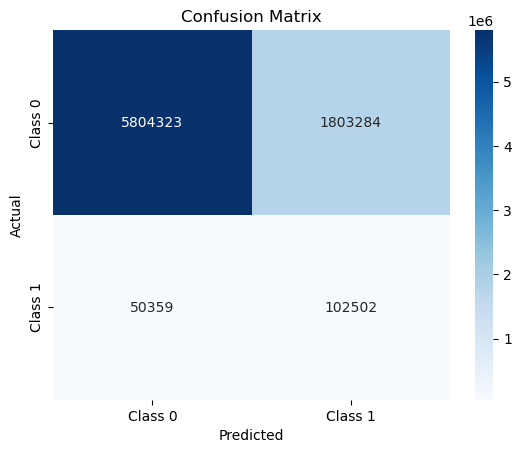

训练集Confusion Matrix:
[[5804323 1803284]
 [  50359  102502]]


In [30]:
cm = confusion_matrix(y_train, y_pred_train)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("training confusion matrix:")
print(cm)

In [31]:
# F1-score & ROC-AUC
y_prob_train = rf_model.predict_proba(X_train)[:, 1]
f1_train = f1_score(y_train, y_pred_train)
roc_auc_train = roc_auc_score(y_train, y_prob_train)

print(f"F1-score of training: {f1_train}")
print(f"ROC-AUC of training: {roc_auc_train}")

F1-score of training: 0.09958190986604308
ROC-AUC of training: 0.7944556916846033


### Predict test set

In [32]:
y_pred_test = rf_model.predict(X_test)

# acc
accuracy_train = accuracy_score(y_test, y_pred_test)
print(f"testing accuracy: {accuracy_train:.2f}")

测试集模型准确率: 0.76


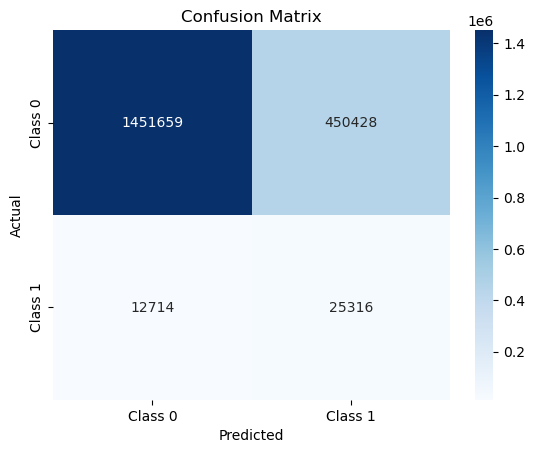

Confusion Matrix:
[[1451659  450428]
 [  12714   25316]]


In [34]:
cm = confusion_matrix(y_test, y_pred_test)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("testing confusion matrix:")
print(cm)

In [36]:
# F1-score & ROC-AUC
y_prob = rf_model.predict_proba(X_test)[:, 1]
f1 = f1_score(y_test, y_pred_test)
roc_auc = roc_auc_score(y_test, y_prob)

print(f"F1-score of testing: {f1}")
print(f"ROC-AUC of testing: {roc_auc}")

F1-score of testing: 0.09854916753280625
ROC-AUC of testing: 0.7926989187783614


### Feature importance

Feature Importances:
Origin_HourlyWindGustSpeed: 0.0116
Origin_HourlyDryBulbTemperature: 0.0048
Origin_HourlyPrecipitation: 0.0030
DayOfWeek: 0.0017
DepTimeBlk: 0.0012
ArrTimeBlk: 0.0012
Distance: 0.0011
Operating_Airline : 0.0009
Origin: 0.0009
Origin_HourlyAltimeterSetting: 0.0008
Dest: 0.0007
Dest_HourlyWindSpeed: 0.0006
Dest_HourlyRelativeHumidity: 0.0005
Dest_HourlyWindGustSpeed: 0.0005
Origin_HourlyRelativeHumidity: 0.0003
Origin_HourlyWindDirection: 0.0002
Dest_HourlyVisibility: 0.0002
Origin_HourlyWindSpeed: 0.0002
Dest_HourlyDryBulbTemperature: 0.0001
Origin_HourlyVisibility: 0.0001
Holiday: 0.0001
Dest_HourlyAltimeterSetting: 0.0001
Origin_HourlySeaLevelPressure: 0.0001
Dest_HourlyWindDirection: 0.0001
Dest_HourlyDewPointTemperature: 0.0001
Dest_HourlyPrecipitation: 0.0000
Origin_HourlyDewPointTemperature: 0.0000
Dest_HourlySeaLevelPressure: 0.0000


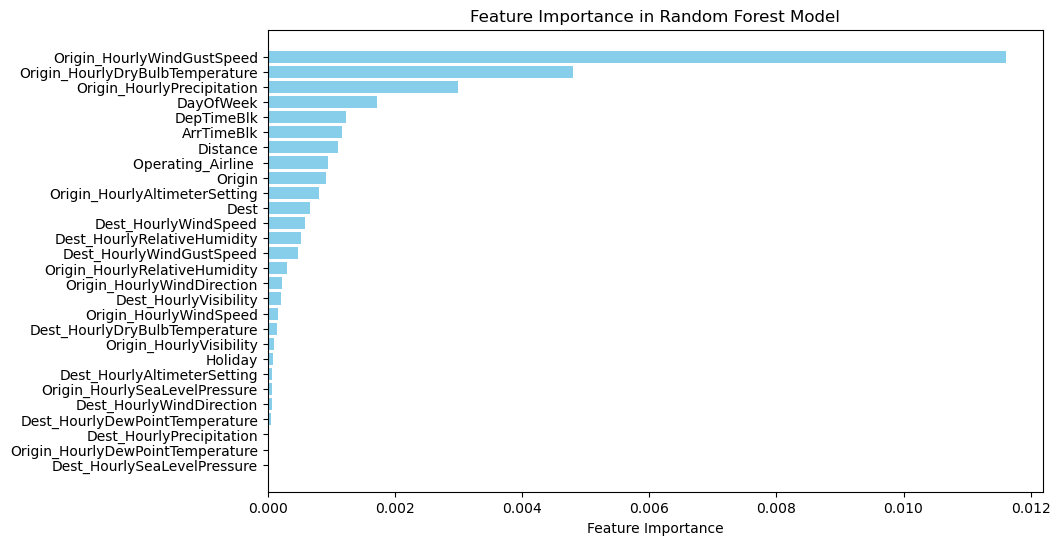

In [37]:
feature_names = X.columns

importances = rf_model.feature_importances_

feature_importances = sorted(zip(importances, feature_names), reverse=True)

print("Feature Importances:")
for importance, name in feature_importances:
    print(f"{name}: {importance:.4f}")

importances, names = zip(*feature_importances)
plt.figure(figsize=(10, 6))
plt.barh(names, importances, color="skyblue")
plt.xlabel("Feature Importance")
plt.title("Feature Importance in Random Forest Model")
plt.gca().invert_yaxis()  
plt.show()

# Random forest with SMOTE

In [19]:
rf_model_SMOTE = RandomForestClassifier(n_estimators=50, max_depth=8, max_features="sqrt", n_jobs=-1, random_state=123, warm_start=True)

for i in tqdm(range(1, rf_model_SMOTE.n_estimators + 1), desc="Training Progress"):
    rf_model_SMOTE.n_estimators = i  # Gradually increase the number of trees
    rf_model_SMOTE.fit(X_resampled, y_resampled)

print("Got it!")

Training Progress: 100%|███████████████████████████████████████████████████████████████| 50/50 [44:04<00:00, 52.89s/it]

Got it!


In [20]:
# save the model
dump(rf_model_SMOTE, "cancel_randomforest_SMOTE.joblib")

with open('cancel_randomforest_SMOTE.pkl', 'wb') as file:
    pickle.dump(rf_model_SMOTE, file)

### Predict training set

In [21]:
y_pred_SMOTE_train = rf_model_SMOTE.predict(X_resampled)

# acc
accuracy_SMOTE_train = accuracy_score(y_resampled, y_pred_SMOTE_train)
print(f"traing accuracy: {accuracy_SMOTE_train:.2f}")

traing accuracy: 0.95


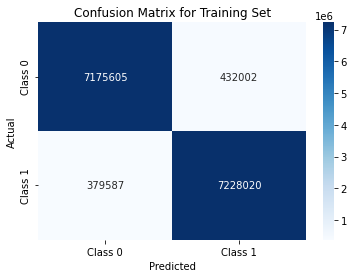

Confusion Matrix for Training Set:
[[7175605  432002]
 [ 379587 7228020]]


In [22]:
cm = confusion_matrix(y_resampled, y_pred_SMOTE_train)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Training Set')
plt.show()

print("Confusion Matrix for Training Set:")
print(cm)

In [23]:
# F1-score & ROC-AUC
y_prob_train_SMOTE = rf_model_SMOTE.predict_proba(X_resampled)[:, 1]
f1_train_SMOTE = f1_score(y_resampled, y_pred_SMOTE_train)
roc_auc_train_SMOTE = roc_auc_score(y_resampled, y_prob_train_SMOTE)

print(f"F1-score of training: {f1_train_SMOTE}")
print(f"ROC-AUC of training: {roc_auc_train_SMOTE}")

F1-score of training: 0.9468424992511935
ROC-AUC of training: 0.9867502757406614


### Predict test set

In [24]:
y_pred_SMOTE_test = rf_model_SMOTE.predict(X_test)

accuracy_SMOTE_test = accuracy_score(y_test, y_pred_SMOTE_test)
print(f"testing set accuracy: {accuracy_SMOTE_test:.2f}")

testing set accuracy: 0.93


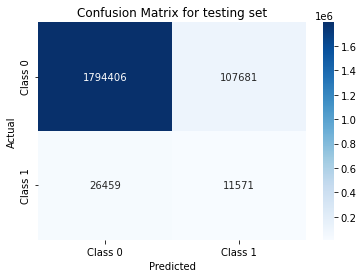

Confusion Matrix for testing set:
[[1794406  107681]
 [  26459   11571]]


In [25]:
cm = confusion_matrix(y_test, y_pred_SMOTE_test)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for testing set')
plt.show()

print("Confusion Matrix for testing set:")
print(cm)

In [26]:
# F1-score & ROC-AUC
y_prob_test_SMOTE = rf_model_SMOTE.predict_proba(X_test)[:, 1]
f1_test_SMOTE = f1_score(y_test, y_pred_SMOTE_test)
roc_auc_test_SMOTE = roc_auc_score(y_test, y_prob_test_SMOTE)

print(f"F1-score of testing: {f1_test_SMOTE}")
print(f"ROC-AUC of testing: {roc_auc_test_SMOTE}")

F1-score of testing: 0.14713698961101718
ROC-AUC of testing: 0.7722722442107396


Feature Importances:
Operating_Airline : 0.0307
Origin_HourlyWindGustSpeed: 0.0274
Origin: 0.0255
Origin_HourlyDryBulbTemperature: 0.0229
DayOfWeek: 0.0211
DepTimeBlk: 0.0199
Distance: 0.0168
Dest: 0.0157
ArrTimeBlk: 0.0153
Dest_HourlyWindSpeed: 0.0023
Origin_HourlyPrecipitation: 0.0015
Origin_HourlyAltimeterSetting: 0.0012
Dest_HourlyVisibility: 0.0003
Origin_HourlySeaLevelPressure: 0.0002
Dest_HourlyWindGustSpeed: 0.0002
Dest_HourlyWindDirection: 0.0001
Dest_HourlyAltimeterSetting: 0.0000
Dest_HourlyDewPointTemperature: 0.0000
Holiday: 0.0000
Dest_HourlyDryBulbTemperature: 0.0000
Dest_HourlyRelativeHumidity: 0.0000
Origin_HourlyRelativeHumidity: 0.0000
Dest_HourlyPrecipitation: 0.0000
Origin_HourlyWindSpeed: 0.0000
Origin_HourlyVisibility: 0.0000
Dest_HourlySeaLevelPressure: 0.0000
Origin_HourlyWindDirection: 0.0000
Origin_HourlyDewPointTemperature: 0.0000


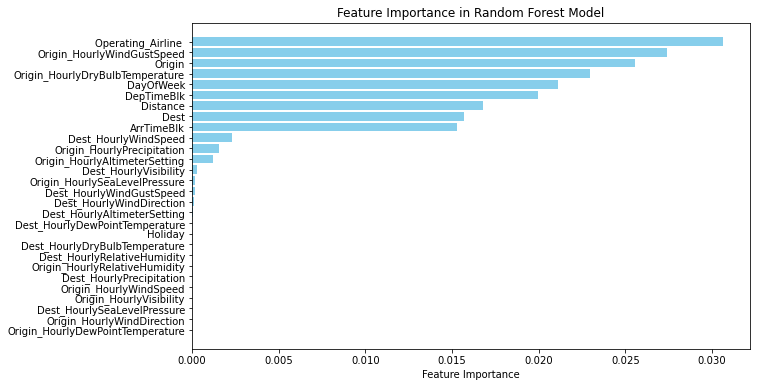

In [27]:
feature_names = X.columns

importances = rf_model_SMOTE.feature_importances_

feature_importances = sorted(zip(importances, feature_names), reverse=True)

print("Feature Importances:")
for importance, name in feature_importances:
    print(f"{name}: {importance:.4f}")

importances, names = zip(*feature_importances)
plt.figure(figsize=(10, 6))
plt.barh(names, importances, color="skyblue")
plt.xlabel("Feature Importance")
plt.title("Feature Importance in Random Forest Model")
plt.gca().invert_yaxis()  
plt.show()